# Data Analysis
- This is a data analysis using Yelp dataset downloaded in March 2019, and using aspects of the Yelp reviews I extracted
- by Xiaoyi Yuan, for paper Crowdsourcing the Urban Food Scene

- Notes to myself
    - res_business.json has 1 more unique business_id than res_review_cat.json
    - a few businesses in res_business.json has no postal_code, I ignored those in function one_hot_encoding()

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import descartes
import json
%matplotlib inline

## General Stats about Yelp Dataset

In [2]:
all_business = "../data/official_data/yelp_dataset/business.json"
files = open(all_business)
n=0
for f in files:
    n+=1
print("Total number of businesses in the Yelp dataset is ", n)

Total number of businesses in the Yelp dataset is  192609


## General stats for analysis data

- This analysis uses the following datasets: 
    - **res_review_cat.json** (Yelp review data with restaurant only and with (aspect)"categories" added to it.)
    - **res_business.json** (Yelp business data with restaurant only.)
- First get rid of "reviews" and export it to a pickle file to make data smaller and easier for further analysis.
- Then read both data in.

In [3]:
def exportSmallerData():
    path = "../data/result_data/res_review_cat.json"
    data = pd.read_json(path)
    output = data[["business_id", "review_id", "user_id", "aspect_categories"]]
    output.to_pickle("../data/result_data/res_cat.pickle")
# exportSmallerData()

- read res_cat.pkl back in and read res_business.json

In [4]:
path = "../data/result_data/"

In [5]:
review = pd.read_pickle(path + "res_cat.pickle")
business = pd.read_json("../data/prep_data_yelp/res_business.json")
print("There are ", len(review), "reviews in the data.")
print("There are ", len(business), "restaurants in the data.")
print("Each business on average has ", len(review)/len(business), "reviews.")

There are  3399993 reviews in the data.
There are  37818 restaurants in the data.
Each business on average has  89.90409328891005 reviews.


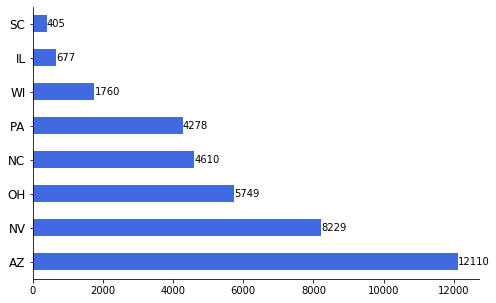

In [412]:
# Distribution of businesses among selected states
df = pd.DataFrame(business['state'].value_counts())
ax = df.plot(kind='barh', rot=0, figsize=(8,5), color='royalblue', legend=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i, v in enumerate(list(df['state'])):
    ax.text(v+5, i, str(v), va='center',color='black')
ax.tick_params(axis="y", labelsize=12) 
ax.tick_params(axis="x", labelsize=10)
fig = ax.get_figure()
fig.savefig("../data/result_data/business_distribution.png",dpi=400, bbox_inches='tight')

In [7]:
review.head(3)

business_id               review_id                 user_id  \
0  eU_713ec6fTGNO4BegRaww  fdiNeiN_hoCxCMy2wTRW9g  w31MKYsNFMrjhWxxAb5wIw   
1  zvO-PJCpNk4fgAVUnExYAA  8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA   
2  b2jN2mm9Wf3RcrZCgfo1cg  qrffudO73zsslZbe8B9D3Q  sG_h0dIzTKWa3Q6fmb4u-g   

                                   aspect_categories  \
0  [, menu, price, food, food, food, portion, foo...   
1        [place, service, food, food, service, menu]   
2  [drink, dessert, food, , food, drink, drink, q...   

                                             aspects  
0  [Tavolta, menu, overpriced, pasta, sea bass, C...  
1       [place, staff, food, food, service, options]  
2  [beers, Vanilla Stout, DIPA, Ironclad, Chuck B...

In [8]:
business.head(3)

address  \
0  10110 Johnston Rd, Ste 15   
1    2450 E Indian School Rd   
2            5981 Andrews Rd   

                                          attributes             business_id  \
0  {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...  gnKjwL_1w79qoiV3IC_xQQ   
1  {'RestaurantsTakeOut': 'True', 'BusinessParkin...  1Dfx3zM-rW4n-31KeC8sJg   
2  {'RestaurantsPriceRange2': '2', 'BusinessAccep...  fweCYi8FmbJXHCqLnwuk8w   

                                          categories                city  \
0                  Sushi Bars, Restaurants, Japanese           Charlotte   
1  Restaurants, Breakfast & Brunch, Mexican, Taco...             Phoenix   
2         Italian, Restaurants, Pizza, Chicken Wings  Mentor-on-the-Lake   

                                               hours  is_open   latitude  \
0  {'Monday': '17:30-21:30', 'Wednesday': '17:30-...        1  35.092564   
1  {'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...        1  33.495194   
2  {'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ...        1  41.708520   

    longitude                         name postal_code  review_count  stars  \
0  -80.859132  Musashi Japanese Restaurant       28210           170    4.0   
1 -112.028588                    Taco Bell       85016            18    3.0   
2  -81.359556                Marco's Pizza       44060            16    4.0   

  state  
0    NC  
1    AZ  
2    OH

In [9]:
categories = ['chef', 'ingredient', 'quality', 'portion', 'texture', 'taste', 'menu', 
              'atmosphere','experience', 'interior','location','reservation', 'crowded', 
              'service','food', 'dessert', 'drink', 'place']
exclude=['food', 'dessert', 'drink', 'place']
def normalize(aspect_categories):
    # get the proportion of each aspect in a review
    s = set(aspect_categories)
    s = [i for i in s if i in categories]
    frequencies = np.array([0]*len(categories))
    for item in s:
        frequency = aspect_categories.count(item)
        index = categories.index(item)
        frequencies[index] = frequency
    if sum(frequencies) != 0:
        normalized = np.array([i/sum(frequencies) for i in frequencies])
        return normalized
    else:
        return frequencies

def normalize2(aspect_categories):
    # if one aspect appear in the review, count it as 1, repetitions don't count
    s = set(aspect_categories)
    s = [i for i in s if i in categories]
    counts = np.array([0]*len(categories))
    for item in s:
        index = categories.index(item)
        counts[index] = 1
    return counts

In [10]:
review['cat'] = review['aspect_categories'].apply(normalize)

In [11]:
review[categories] = pd.DataFrame(review['cat'].values.tolist(),columns=categories)
review = review[review[categories].sum(axis=1) != 0] #get rid of rows that are all 0
new_review = pd.merge(review, business, on='business_id', how='left')
# get price range (some attributes are None and some attributes does not have price range, both return None)
new_review['price_range'] = new_review['attributes'].apply(lambda x:x.get('RestaurantsPriceRange2') if x!= None else None)

In [12]:
len(new_review.groupby('business_id'))

37817

In [13]:
len(new_review)

3369960

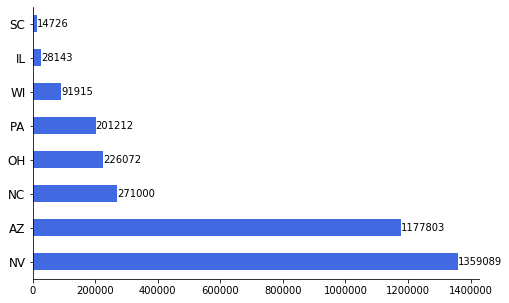

In [413]:
# Distribution of reviews among selected states
df = pd.DataFrame(new_review['state'].value_counts())
ax = df.plot(kind='barh', rot=0, figsize=(8,5), color='royalblue',legend=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for i, v in enumerate(list(df['state'])):
    ax.text(v+5, i, str(v), va='center',color='black')
ax.tick_params(axis="y", labelsize=12) 
ax.tick_params(axis="x", labelsize=10)
fig = ax.get_figure()
fig.savefig("../data/result_data/review_distribution.png",dpi=400, bbox_inches='tight')

In [15]:
# general statistics about the control factors:
price = new_review[(new_review['price_range']!='None')&(new_review['price_range'].notnull())]['price_range'].astype('int')
star, numreview = new_review['stars'], new_review['review_count']
summary = pd.concat([price.describe(), star.describe(), numreview.describe()], axis=1).round(decimals=2)
summary

price_range       stars  review_count
count   3334240.00  3369960.00    3369960.00
mean          1.83        3.74        583.89
std           0.64        0.61        994.40
min           1.00        1.00          3.00
25%           1.00        3.50        102.00
50%           2.00        4.00        261.00
75%           2.00        4.00        606.00
max           4.00        5.00       8348.00

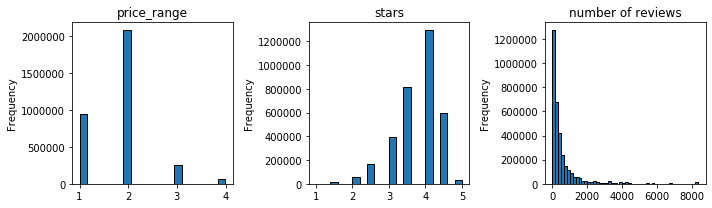

In [392]:
fig, axes = plt.subplots(nrows=1, ncols=3)
color='tab:blue'
edgecolor='black'
price.plot('hist', bins=20, ax=axes[0], title='price_range', figsize=(10,3), edgecolor=edgecolor, color=color)
star.plot('hist', bins=20, ax=axes[1], title='stars', figsize=(10,3), edgecolor=edgecolor, color=color)
numreview.plot('hist', bins=50, ax=axes[2], title='number of reviews', figsize=(10,3), edgecolor=edgecolor, color=color)
fig.tight_layout()
fig.savefig("../data/result_data/factors_summary.png",dpi=400, bbox_inches='tight')

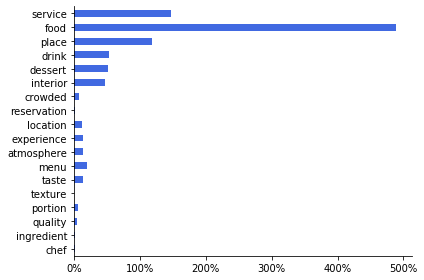

In [398]:
df = new_review[categories]
df2 = pd.DataFrame(df.mean())
ax=df2.plot(kind='barh', legend=False, color='royalblue')
vals = ax.get_yticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("../data/result_data/avg_categories.png",dpi=400, bbox_inches='tight')

## Either "food" or "service"

In [18]:
# correlation analysis 
df = new_review[categories]
corr = df.corr()
corr

chef  ingredient   quality   portion   texture     taste  \
chef         1.000000    0.002410  0.001191 -0.004857  0.000205 -0.004025   
ingredient   0.002410    1.000000  0.008427  0.001081  0.003635  0.015047   
quality      0.001191    0.008427  1.000000  0.008329 -0.000827  0.005220   
portion     -0.004857    0.001081  0.008329  1.000000 -0.002633  0.003738   
texture      0.000205    0.003635 -0.000827 -0.002633  1.000000  0.044219   
taste       -0.004025    0.015047  0.005220  0.003738  0.044219  1.000000   
menu         0.003274    0.005364 -0.005430 -0.000631 -0.004973 -0.018493   
atmosphere  -0.005185   -0.009079 -0.010580 -0.009066 -0.008091 -0.028632   
experience   0.010599   -0.008955 -0.005363 -0.017810 -0.004702 -0.023433   
interior    -0.015494   -0.019794 -0.018926 -0.032133 -0.009598 -0.047909   
location    -0.010737   -0.005242 -0.000577 -0.016071 -0.006271 -0.023970   
reservation  0.003240   -0.005304 -0.005022 -0.004867 -0.002184 -0.011742   
crowded     -0.004662   -0.008740 -0.007100 -0.006037 -0.005628 -0.024217   
service     -0.011607   -0.033952 -0.025060 -0.045065 -0.026290 -0.101235   
food        -0.020764   -0.014501 -0.048305 -0.031019 -0.002035 -0.052425   
dessert     -0.013866   -0.006091 -0.022187 -0.028321  0.026633  0.068988   
drink       -0.021113   -0.021209 -0.028543 -0.044544 -0.009338 -0.033957   
place       -0.010508   -0.022938 -0.018475 -0.029517 -0.017899 -0.063906   

                 menu  atmosphere  experience  interior  location  \
chef         0.003274   -0.005185    0.010599 -0.015494 -0.010737   
ingredient   0.005364   -0.009079   -0.008955 -0.019794 -0.005242   
quality     -0.005430   -0.010580   -0.005363 -0.018926 -0.000577   
portion     -0.000631   -0.009066   -0.017810 -0.032133 -0.016071   
texture     -0.004973   -0.008091   -0.004702 -0.009598 -0.006271   
taste       -0.018493   -0.028632   -0.023433 -0.047909 -0.023970   
menu         1.000000   -0.003116   -0.015708 -0.025201 -0.022275   
atmosphere  -0.003116    1.000000   -0.009734 -0.005365 -0.022775   
experience  -0.015708   -0.009734    1.000000 -0.008240 -0.001872   
interior    -0.025201   -0.005365   -0.008240  1.000000 -0.003462   
location    -0.022275   -0.022775   -0.001872 -0.003462  1.000000   
reservation -0.002921   -0.003341    0.009626  0.011633 -0.008451   
crowded     -0.016769   -0.015999   -0.002480 -0.004030 -0.001250   
service     -0.064317   -0.028250    0.030382 -0.063306  0.002936   
food        -0.105496   -0.127453   -0.135142 -0.301969 -0.137656   
dessert     -0.034183   -0.045995   -0.038082 -0.063242 -0.032607   
drink       -0.025139    0.017783   -0.029495  0.009807 -0.022038   
place       -0.041517   -0.008059   -0.048455 -0.006300 -0.060815   

             reservation   crowded   service      food   dessert     drink  \
chef            0.003240 -0.004662 -0.011607 -0.020764 -0.013866 -0.021113   
ingredient     -0.005304 -0.008740 -0.033952 -0.014501 -0.006091 -0.021209   
quality        -0.005022 -0.007100 -0.025060 -0.048305 -0.022187 -0.028543   
portion        -0.004867 -0.006037 -0.045065 -0.031019 -0.028321 -0.044544   
texture        -0.002184 -0.005628 -0.026290 -0.002035  0.026633 -0.009338   
taste          -0.011742 -0.024217 -0.101235 -0.052425  0.068988 -0.033957   
menu           -0.002921 -0.016769 -0.064317 -0.105496 -0.034183 -0.025139   
atmosphere     -0.003341 -0.015999 -0.028250 -0.127453 -0.045995  0.017783   
experience      0.009626 -0.002480  0.030382 -0.135142 -0.038082 -0.029495   
interior        0.011633 -0.004030 -0.063306 -0.301969 -0.063242  0.009807   
location       -0.008451 -0.001250  0.002936 -0.137656 -0.032607 -0.022038   
reservation     1.000000  0.019904  0.004808 -0.049991 -0.013521 -0.013132   
crowded         0.019904  1.000000 -0.014314 -0.084619 -0.026459 -0.024492   
service         0.004808 -0.014314  1.000000 -0.424668 -0.141722 -0.065852   
food           -0.049991 -0.084619 -0.424668  1.000000 -0.242033 -0.317

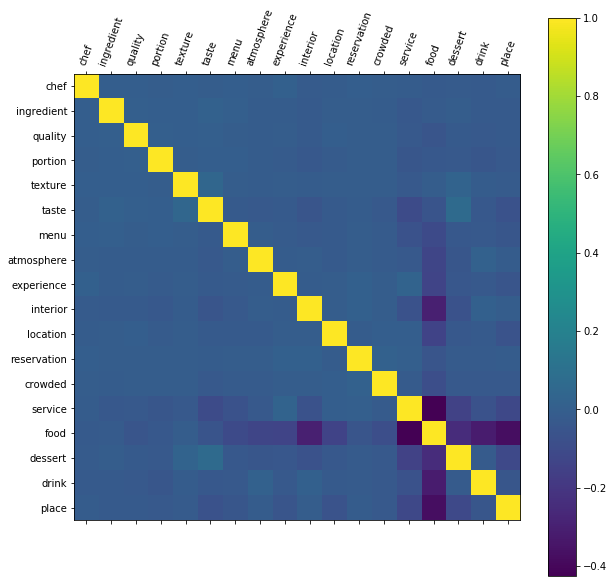

In [19]:
f = plt.figure(figsize=(10, 10))
ax = plt.matshow(corr,fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=70)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
f.savefig("../data/result_data/corr_matrix.png",dpi=400, bbox_inches='tight')

## Homogeneity amaong cities

In [20]:
# value count of cities for the selected state
df = pd.DataFrame(new_review['city'].value_counts())
df.columns=['count']
df[:20]

count
Las Vegas        1212162
Phoenix           418585
Scottsdale        226147
Charlotte         205957
Pittsburgh        158663
Tempe             115920
Henderson         110993
Chandler           89523
Mesa               87402
Cleveland          82615
Madison            72887
Gilbert            70729
Glendale           56031
Peoria             29809
North Las Vegas    25334
Champaign          20693
Surprise           20447
Goodyear           17003
Lakewood           13482
Avondale           12203

- mapping the locations of businesses

In [21]:
import geopandas as gpd

In [22]:
city1 = 'Las Vegas'
city2 = 'Phoenix'
city3 = 'Charlotte'
city4 = 'Pittsburgh'
city5 = "Madison"
city6 = "Champaign"

In [23]:
cbsa = gpd.read_file("../data/official_data/tl_2015_us_cbsa/tl_2015_us_cbsa.shp")

In [24]:
nv = cbsa[cbsa['NAME'].str.contains('Las Vegas')].iloc[0]
az = cbsa[cbsa['NAME'].str.contains('Phoenix')]
nc = cbsa[cbsa['NAME'].str.contains('Charlotte')].iloc[0]
pa = cbsa[cbsa['NAME'].str.contains('Pittsburgh')]
wi = cbsa[cbsa['NAME'].str.contains('Wisconsin')]
il = cbsa[cbsa['NAME'].str.contains('Champaign')]

In [354]:
def mapping(cbsa_state, state, legend_anchor, xlim=False, ylim=False):
    business_state = business[business['state']==state]
    states1=['NV','AZ','PA']
    states2=['NC','WI','IL']
    if state in states1:
        business_cities = business_state['city'].value_counts()[:6]
    else:
        business_cities = business_state['city'].value_counts()[:3]
    loc = business_state[business_state['city'].isin(business_cities.index)]
    res = gpd.GeoDataFrame(loc, geometry=gpd.points_from_xy(loc.longitude, loc.latitude))
    
    # base = cbsa_state.plot(color='white', edgecolor='black', figsize=(6, 6))
    ax= res.plot(column='city', cmap='Set2', markersize=1, marker='o', legend=True)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    if xlim and ylim:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    leg = ax.get_legend()
    leg.set_bbox_to_anchor(legend_anchor)
    leg.set_alpha(50)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig = ax.get_figure()
    fig.savefig("../../paper/table_graphs/map"+state+".png",figsize=(8, 6),dpi=400, bbox_inches='tight')

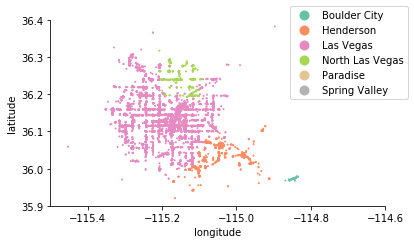

In [355]:
mapping(nv, "NV", (0.7, 1.1), (-115.5, -114.6),(35.9, 36.4))

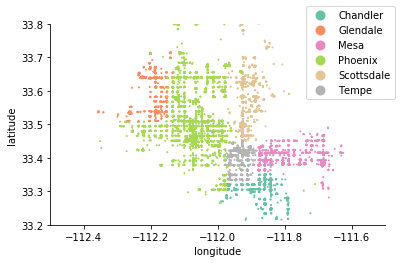

In [356]:
mapping(az, "AZ",(0.75,0.6),(-112.5,-111.5),(33.2,33.8))

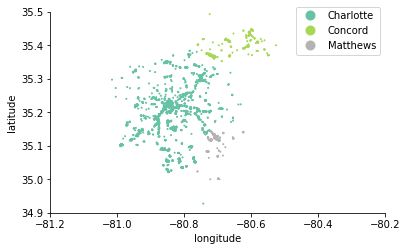

In [357]:
mapping(nc, "NC", (1,1.05), (-81.2, -80.2),(34.9, 35.5))

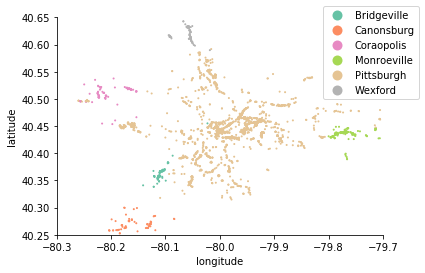

In [358]:
mapping(pa, 'PA', (0.8, 0.6), (-80.3, -79.7),(40.25, 40.65))

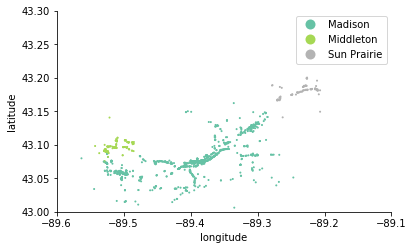

In [359]:
mapping(wi, 'WI',(1, 1),(-89.6, -89.1),(43, 43.3))

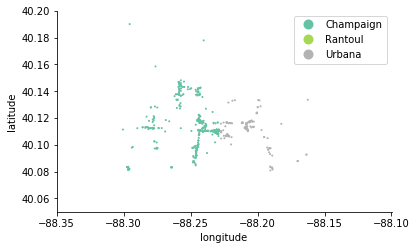

In [360]:
mapping(il, 'IL', (1,1),(-88.35, -88.10),(40.05, 40.20))

- visualize aspects in the 6 cities

/Users/xiaoyi/environments/absa_project/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/Users/xiaoyi/environments/absa_project/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  func(*args, **kwargs)
/Users/xiaoyi/environments/absa_project/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


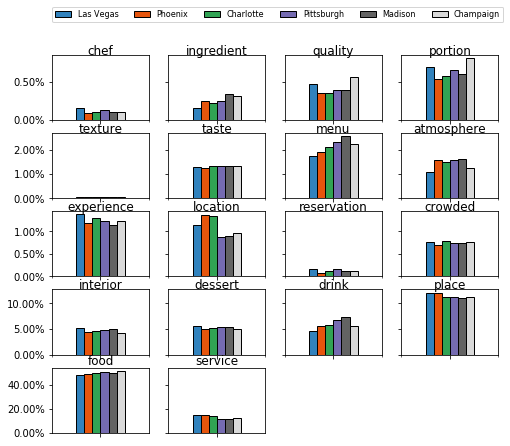

In [32]:
categories = ['chef', 'ingredient', 'quality', 'portion', 'texture', 'taste', 'menu', 
              'atmosphere','experience','location','reservation', 'crowded', "interior",
             'dessert', 'drink', 'place','food','service']
city1 = 'Las Vegas'
city2 = 'Phoenix'
city3 = 'Charlotte'
city4 = 'Pittsburgh'
city5 = "Madison"
city6 = "Champaign"
cities=[city1, city2, city3, city4, city5, city6]

fig, axes = plt.subplots(nrows=5, ncols=4, sharey='row', tight_layout=True)
cmap = 'tab20c'
edgecolor = 'black'
size=(8,6)
for i in range(len(categories)):   
    category = categories[i]
    df = pd.DataFrame()
    for city in cities:
         df.loc[0,city] = new_review[new_review['city']==city][category].mean()
    if i == 0:
        ax=df.plot(kind='bar', ax=axes[i//4, i%4], cmap=cmap, sharey=True,
            edgecolor=edgecolor, figsize=size, sharex=True, legend=True)
        ax.legend(bbox_to_anchor=(0., 1.5), loc=3, ncol=6,
                  borderaxespad=0, frameon=True,prop={'size': 8})
    else:
        ax=df.plot(kind='bar', ax=axes[i//4, i%4], cmap=cmap, sharey=True,
            edgecolor=edgecolor, figsize=size, sharex=True, title=category, legend=False)
    ax.set_title(category, pad=0.5)
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
    ax.set_xticklabels([])
    axes[-1, -1].axis('off')
    axes[-1, -2].axis('off')
    plt.subplots_adjust(top=1)
fig.savefig("../data/result_data/homogeneity_cities.png",dpi=400, bbox_inches='tight')

## Single Location Restaurant vs Chain Restaurant

In [418]:
num_locations = business['name'].value_counts()
sl = business[business['name'].isin(num_locations[num_locations==1].index)]
chain = business[business['name'].isin(num_locations[num_locations>1].index)]

city1 = 'Las Vegas'
city2 = 'Phoenix'
city3 = 'Charlotte'
city4 = 'Pittsburgh'
city5 = "Madison"
city6 = "Champaign"
cities=[city1, city2, city3, city4, city5, city6] 

In [419]:
kind = new_review
kind = kind[kind['categories'].str.contains("Fast Food")]
kind = kind[(kind['price_range']=='1') |(kind['price_range']=='2') ]
kind = kind[kind['city'].isin(cities)]
sl_review = kind[kind['business_id'].isin(sl['business_id'])]
chain_review = kind[kind['business_id'].isin(chain['business_id'])]

In [420]:
from collections import defaultdict
def getDict(review):
    aspects=list(review['aspects'])
    cat = list(review['aspect_categories'])
    temp = defaultdict(set)
    for num in range(len(cat)):
        for delvt, pin in zip(cat[num], aspects[num]):
            temp[delvt].add(pin)
    return temp
dict1 = getDict(sl_review)
dict2 = getDict(chain_review)

In [489]:
def plot(sl_review, chain_review, dict1, dict2, name):
    df = pd.DataFrame()
    for category in categories:
        size1 = len(dict1[category])/len(sl_review)
        size2 = len(dict2[category])/len(chain_review)
        mean = (size1+size2)/2
        if mean == 0:
             df[category]= pd.Series([0, 0])
        else:
            df[category]=pd.Series([size1/mean, size2/mean])
    df=df.transpose()
    df.columns=['independent', 'chain']
    ax=df.plot(kind='barh', cmap='Paired', width=0.6, alpha=0.8,figsize=(8,6))
    vals = ax.get_yticks()
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1),
              ncol=2, fancybox=True, shadow=True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig = ax.get_figure()
    fig.savefig("../data/result_data/"+name+".png",dpi=400, bbox_inches='tight')

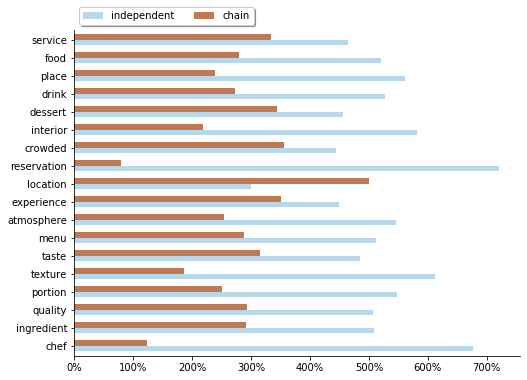

In [490]:
plot(sl_review, chain_review, dict1, dict2, "slchain1")

In [155]:
# from collections import defaultdict
# y_aspect=list(y['aspects'])
# y_cat = list(y['aspect_categories'])
# tempy = defaultdict(set)
# for num in range(len(y_cat)):
#     for delvt, pin in zip(y_cat[num], y_aspect[num]):
#         tempy[delvt].add(pin)

- recreate the plot from different cities and different cuisine

In [72]:
# bar graph
from matplotlib.ticker import FuncFormatter
def plot2(kind, name):
    cities = ['Las Vegas', 'Phoenix', 'Charlotte']
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharey=True,tight_layout=True)
    cities = [city1, city2, city3]
    for i in range(len(cities)):
        city = cities[i]
        kindd = kind[kind['city']==city]
        sl_review = kindd[kindd['business_id'].isin(sl['business_id'])]
        chain_review = kindd[kindd['business_id'].isin(chain['business_id'])]
        dict1 = getDict(sl_review)
        dict2 = getDict(chain_review)
        
        df = pd.DataFrame()
        for category in categories:
            size1 = len(dict1[category])/len(sl_review)
            size2 = len(dict2[category])/len(chain_review)
            mean = (size1+size2)/2
            if mean == 0:
                 df[category]= pd.Series([0, 0])
            else:
                df[category]=pd.Series([size1/mean, size2/mean])
        df=df.transpose()
        df.columns=['independent', 'chain']
        
        ax=df.plot(kind='bar', cmap='Paired', edgecolor='black', ax=axes[i], legend=False)
        ax.set_xticklabels(categories,rotation=60, ha='right')
        ax.set_title(city)
        ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
        if i == 0:
            ax.legend(loc='lower left', bbox_to_anchor=(0, 1.1),
                  ncol=2, fancybox=True, shadow=True)
    fig.savefig("../data/result_data/"+name+".png",dpi=400, bbox_inches='tight')

In [495]:
# radar charts
from math import pi
def plot3(kind, name, legend=True):
    cities = ['Las Vegas', 'Phoenix', 'Charlotte']
    fig, (ax1, ax2, ax3)= plt.subplots(nrows=1, ncols=3,figsize=(18, 14), subplot_kw=dict(polar=True), 
                                       tight_layout=True)
    if legend:
        plt.figtext(0.3,0.7,"independent",color="red", fontsize=15,weight='bold',
                   bbox=dict(facecolor='none', edgecolor='red',  boxstyle='round'))
        plt.figtext(0.65,0.7,"chain",color="teal",fontsize=15,weight='bold',
                   bbox=dict(facecolor='none', edgecolor='teal',  boxstyle='round'))
    axes=[ax1, ax2, ax3]
    for i in range(len(cities)):
        city = cities[i]
        kindd = kind[kind['city']==city]
        sl_review = kindd[kindd['business_id'].isin(sl['business_id'])]
        chain_review = kindd[kindd['business_id'].isin(chain['business_id'])]
        dict1 = getDict(sl_review)
        dict2 = getDict(chain_review)
        df = pd.DataFrame()
        for category in categories:
            size1 = len(dict1[category])/len(sl_review)
            size2 = len(dict2[category])/len(chain_review)
            mean = (size1+size2)/2
            if mean == 0:
                 df[category]= pd.Series([0, 0])
            else:
                df[category]=pd.Series([size1/mean, size2/mean])
        df=df.transpose()
        df.columns=['independent', 'chain']
        df = df.transpose()
        
        Attributes =list(df)
        AttNo = len(Attributes)
        values1 = df.iloc[0].tolist()
        values1 += values1[:1]
        angles1 = [n / float(AttNo) * 2 * pi for n in range(AttNo)]
        angles1 += angles1 [:1]
        values2 = df.iloc[1].tolist()
        values2 += values1[:1]
        angles2 = [n / float(AttNo) * 2 * pi for n in range(AttNo)]
        angles2 += angles2 [:1]

        ax = axes[i]
        ax.set_title(cities[i], fontsize=15, y=-0.2, weight='bold')
        ax.set_xticks(angles1[:-1])
        ax.set_xticklabels(Attributes)
        ax.set_rlabel_position(95)
        ax.tick_params(axis="x", labelsize=12) 
        ax.tick_params(axis="y", labelsize=7) 
        ax.plot(angles1,values1)
        ax.fill(angles1, values1, 'teal', alpha=0.1)
        ax.plot(angles2,values2)
        ax.fill(angles2, values2, 'red', alpha=0.1)
        ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
        ax.set_ylim(0, 2)
        aligns = ["left", "left", "left","left", 
                  "center","center",
                  "right","right", "right","right","right", "right","right",
                  "center", "center",
                  "left","left", "left"]
        for tick, align in zip(ax.get_xticklabels(), aligns):
            tick.set_ha(align)
    fig.savefig("../data/result_data/"+name+".png",dpi=400, bbox_inches='tight') 

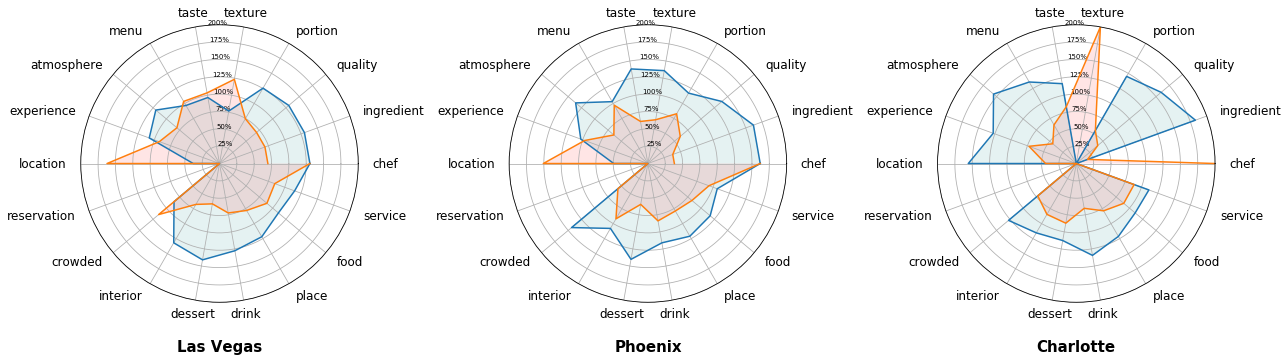

In [496]:
kind = new_review
kind = kind[kind['categories'].str.contains("Fast Food")]
kind = kind[(kind['price_range']=='1') |(kind['price_range']=='2') ]
kind = kind[kind['categories'].str.contains("Asian")]
plot3(kind,"slchain_asian", False)

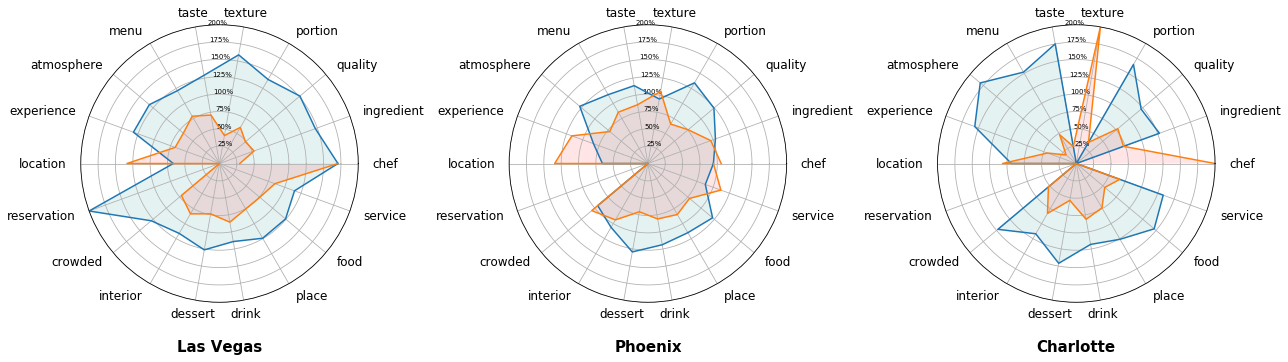

In [497]:
kind = new_review
kind = kind[kind['categories'].str.contains("Fast Food")]
kind = kind[(kind['price_range']=='1') |(kind['price_range']=='2') ]
kind = kind[kind['categories'].str.contains("Mexican")]
plot3(kind,"slchain_mexican", False)

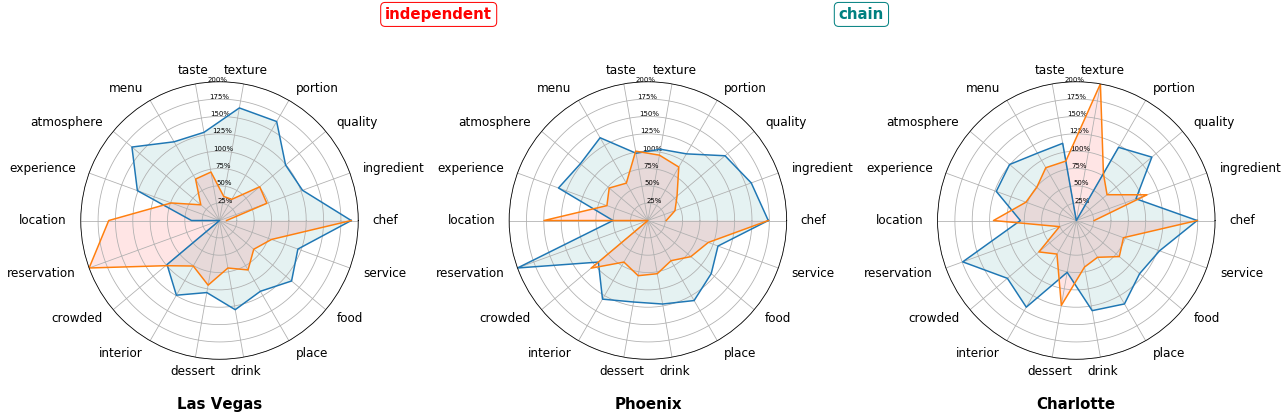

In [498]:
kind = new_review
kind = kind[kind['categories'].str.contains("Fast Food")]
kind = kind[(kind['price_range']=='1') |(kind['price_range']=='2') ]
kind = kind[kind['categories'].str.contains("American")]
plot3(kind, "slchain_american")

In [445]:
import csv
location = list(csv.reader(open("../data/result_data/analysis/location_analysis.csv")))
sl_location = location[0] # all sl location aspects
chain_location_1 = location[1] # chain location characteristics
chain_location_2 = location[2] # chain location with store names
chain_location_3 = location[3] # chain location with place names
total = len(chain_location_1) + len(chain_location_2) + len(chain_location_3)
df = pd.DataFrame([len(chain_location_1)/total, len(chain_location_2)/total,
                   len(chain_location_3)/total])
df.index=['characteristics', 'store names', 'place names']
df * 100


0
characteristics  10.294118
store names      50.980392
place names      38.725490